In [84]:
from pathlib import Path

import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import cufflinks as cf
import matplotlib.pyplot as plt
import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from shapely.geometry import Point

# For Notebooks
init_notebook_mode(connected=True)
# For offline use
cf.go_offline()

## Data description

- Message Types 1, 2, 3, 18, 19, 27 are position messages and
contain values in the position related elds.

- Message Types 5 & 24 are static voyage messages and contain
values in the static details and voyage related elds.

- To identify the Name, IMO number or type of ships related to the
AIS Position reports, the MMSI number must be used to join
together the 2 different sets of AIS data.

- IE if position reports are recorded against MMSI 636018333 in
AIS message type 1 then the IMO and name of that vessel is
discovered by looking for AIS message type 5 reported using the
same MMSI number as shown below

| COLUMN   |      DATA TYPE      |  DESCRIPTIONS |
|----------|:-------------:|------:|
| created_at | date | ISO 8601 formatted timestamp in UTC of the time the vessel record was created |
| timestamp |    string   |   ISO 8601 formatted timestamp in UTC of the time the AIS message was transmitted |
| msg_type| integer |    AIS message type  Common values: 1, 2, 3, 5, 18, 19, 24, 27 AIS message types are explained in more details here (https://faq.spire.com/availableais-message-types)|
| mmsi | integer | The  Maritime Mobile Service Identity of the vessel transmitting the AIS message. Possible values: 000000000 – 999999999|
| latitude | float | Vessel latitude in degrees (range -90 (S) to +90 (N))|
| longitude | float | Vessel longitude in degrees (range = -180 (W) to +180 (E)) |
| speed | number | Vessel speed over ground represented in knots| 0 – 102.2 knots, 102.3 (not available)|
| course | number | Vessel course over ground in degrees (Possible values:0 – 359.9 degrees, 360.0 (not available) |
| heading | number | Vessel true heading in degrees (Possible values: 0 – 359 degrees, 511 (not available) |
| rot | integer | Vessel rate of turn (Possible values: -127 – 127; -128 (not available))|
| imo | integer | IMO number of the ship (Unique International Maritime Organization number for the vessel that stays with the ship for it’s life) valid values 7 digit number|
| name |  string | Vessel name |
| call_sign | string | Vessel call sign |
| draught | float | Vessel draught represented in 1/10 meters (Possible values: 0.1 – 255, 0 (not available; default)) |
|ship_and_cargo_type | integer |Vessel ship and cargo type code. Some common values: 30 (shing vessel), 52 (tug boat), 70 (cargo/shing ship). More info: (https://faq.spire.com/determiningais-ship-type) |
| length | number | Vessel length extracted from ship dimensions to_bow and to_stern in meters|
| width | number |Vessel width extracted from ship dimensions to_port and to_starboard in meters |
| eta | string | Vessel estimated time of arrival  in ISO 8601 format. Possible values: Month: 1 – 12, 0 (not available; default); Day: 1 – 31, 0 (not available; default); Hour: 0 – 23, 24 (not available; default); Minute: 0 –59, 60 (not available; default)|
| destination | string |Vessel destination as entered by the vessel captain |
| status | integer | Vessel navigation status. Some common values: 0 (under way using engine), 1 (at anchor), 3 (restricted maneuverability), 7 (engaged in shing), 15|
| maneuver | integer | Vessel maneuver code. Valid values: 0 (not available; default), 1 (not engaged in special maneuver), 2 (engaged in special maneuver)|
| accuracy | integer | Vessel GPS geo location accuracy in meters. Possible values: 1 (high, <=10 meters); 0 (low, >10 meters, default) |
| collection_type | string | How the message was captured. Possible values: satellite or terrestrial or dynamic |
| to_bow | integer | Distance from AIS transponder to the bow side edge in meters (Hull dimension A) |
| to_stern | integer |Distance from AIS transponder to the stern side edge in meters (Hull dimension B) |
| to_port | integer | Distance from AIS transponder to the port side edge in meters (Hull dimension C) |
| to_starboard | integer | Distance from AIS transponder to the starbord side edge in meters (Hull dimension D) |

## Exploration

Load the CSV and set types

In [70]:
csv_path = Path('../data/ais/DAIS_SouthChinaSea_20200820.csv')
dtypes = {
    'msg_type' : 'category',# np.uint8,
    'mmsi' : 'category',#np.uint64,
    'latitude' : np.float64,
    'longitude' : np.float64,
    'speed' : np.float32,
    'course' : np.float64,
    'heading' : np.float64,
    'rot': np.float32,
    'imo' : 'category',#np.uint8,
    'name' : 'object', # pd.Categorical
    'call_sign' : 'object', # pd.Categorical
    'draught' : np.float32,
    'ship_and_cargo_type' : 'category',# np.uint32,
    'length' : np.float32,
    'width': np.float32,
    'destination' : 'object', # pd.Categorical
    'status' : 'category',# np.uint8,
    'maneuver': 'category', #np.uint8
    'accuracy': 'category',#np.uint8,
    'collection_type' : 'category',#'object', # pd.Categorical
    'to_bow' : np.float32,
    'to_stern' : np.float32, 
    'to_port' : np.float32,
    'to_starboard' : np.float32
}
df = pd.read_csv(csv_path, dtype=dtypes)
for col in ('created_at', 'timestamp', 'eta'):
    df[col] = pd.to_datetime(df[col])

/home/lrm/anaconda3/envs/spire/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (18) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Interpret latitude/longitude with geopandas

In [72]:
# use shapely to interpret appropriate columns
points = df.apply(lambda row: Point(row.latitude, row.longitude), axis=1)
gdf = gpd.GeoDataFrame(df, geometry=points, crs='epsg:4326')

In [75]:
# sample
gdf.head(10)

,created_at,timestamp,mmsi,msg_type,latitude,longitude,speed,course,heading,rot,...,destination,status,maneuver,accuracy,collection_type,to_bow,to_stern,to_port,to_starboard,geometry
0,2020-08-20 23:20:52.957236+00:00,2020-08-20 23:05:17.400000+00:00,352192000,1,16.711835,115.722520,13.5,32.0,31.0,-128.0,...,NaN,15,0,0,dynamic,NaN,NaN,NaN,NaN,POINT (16.712 115.723)
1,2020-08-20 03:46:53.200501+00:00,2020-08-20 04:01:54.130000+00:00,352192000,1,12.894560,113.189590,13.8,34.0,30.0,-128.0,...,NaN,15,0,0,dynamic,NaN,NaN,NaN,NaN,POINT (12.895 113.190)
2,2020-08-20 18:58:54.146592+00:00,2020-08-20 18:44:20.270000+00:00,352192000,1,15.867602,115.192788,13.9,31.0,30.0,-128.0,...,NaN,15,0,0,dynamic,NaN,NaN,NaN,NaN,POINT (15.868 115.193)
3,2020-08-20 11:48:53.639409+00:00,2020-08-20 11:40:05.200000+00:00,352192000,1,14.487857,114.269908,13.9,33.0,33.0,-128.0,...,NaN,15,0,0,dynamic,NaN,NaN,NaN,NaN,POINT (14.488 114.270)
4,2020-08-20 14:49:54.112360+00:00,2020-08-20 14:43:06.960000+00:00,352192000,1,15.075073,114.668483,13.7,30.0,27.0,-128.0,...,NaN,15,0,0,dynamic,NaN,NaN,NaN,NaN,POINT (15.075 114.668)
5,2020-08-20 01:13:53.884127+00:00,2020-08-20 01:05:37.260000+00:00,352192000,1,12.453362,112.891590,14.0,34.0,27.0,-128.0,...,NaN,15,0,0,dynamic,NaN,NaN,NaN,NaN,POINT (12.453 112.892)
6,2020-08-20 00:10:56.311050+00:00,2020-08-20 00:07:47.630000+00:00,352192000,1,12.271700,112.761752,13.7,35.0,30.0,-128.0,...,NaN,15,0,0,dynamic,NaN,NaN,NaN,NaN,POINT (12.272 112.762)
7,2020-08-20 05:42:56.758928+00:00,2020-08-20 05:32:22.260000+00:00,352192000,1,13.312882,113.464995,13.8,33.0,34.0,-128.0,...,NaN,15,0,0,dynamic,NaN,NaN,NaN,NaN,POINT (13.313 113.465)
8,2020-08-20 20:59:57.955051+00:00,2020-08-20 20:55:48.690000+00:00,352192000,1,16.294843,115.467185,14.1,31.0,28.0,-128.0,...,NaN,15,0,0,dynamic,NaN,NaN,NaN,NaN,POINT (16.295 115.467)
9,2020-08-20 17:53:53.830880+00:00,2020-08-20 17:51:46.810000+00:00,352192000,1,15.689925,115.085730,14.0,33.0,31.0,-128.0,...,NaN,15,0,0,dynamic,NaN,NaN,NaN,NaN,POINT (15.690 115.086)


Get a feel for data completeness re missing values:

<AxesSubplot:>

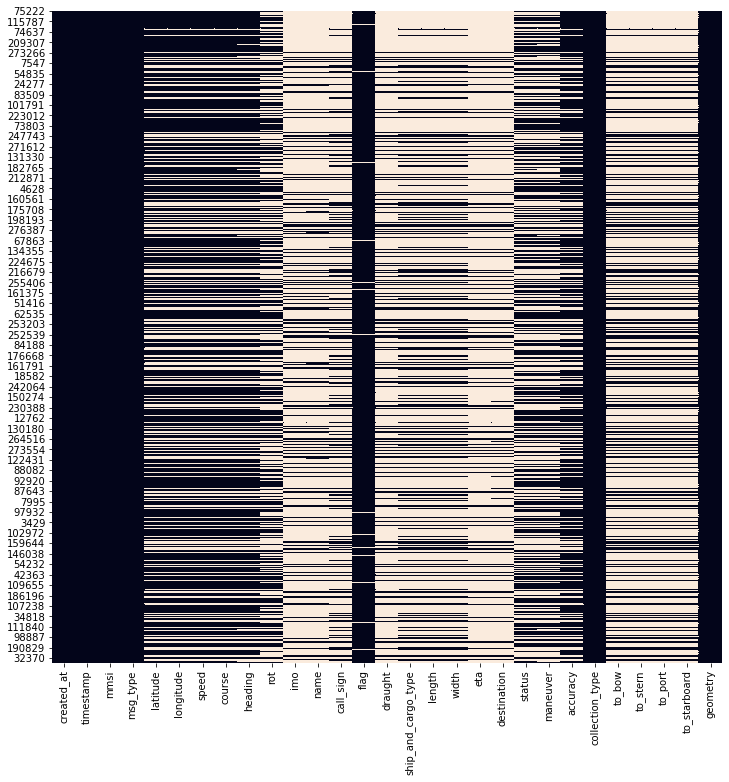

In [76]:
# Investigate patterns in the amount of missing data in each column (with 2000 replaced)
missing_df = gdf.isna()
# number of values used to visualise distribution of missing values (correlation between features etc)
samples_to_plot = 1000
# sample df
plot_sample = missing_df.sample(samples_to_plot)
# plot missing values
fig, ax = plt.subplots(figsize=(12,12))         # Sample figsize in inches
sns.heatmap(plot_sample, ax=ax, cbar=False)

Overall nature and quantity of missing values:

In [87]:
df.isna().sum(axis=0).iplot(kind='bar', title=f'Missing values per feature (of {gdf.shape[0]} total entries)')

To investigate static quantities, get the first entry of each unique ship ID

In [98]:
gdf_first_per_mmsi = gdf.groupby('mmsi').first()

Of the ships that do report their size, what does this distribution look like?

In [ ]:
gdf['surface_area'] = gdf['length'] * gdf['width']
gdf['surface_area'].iplot(kind='hist', title='Ship size (m^2)')

In [105]:
fig = gdf_first_per_mmsi.surface_area.iplot(kind='hist', title='Ship surface area histogram in m^2 (count on logarithmic scale)', asFigure=True)
fig.update_yaxes(type="log")
fig.show()

Looks like there are 14 ships with size in the 128,000 to 129,000 m^2 region.

In [106]:
gdf_big_ships = gdf[gdf['surface_area'] > 120_000]

In [115]:
gdf_big_ships.geometry.is_empty

280308    False
280309    False
280310    False
280311    False
280312    False
          ...  
280829    False
280830    False
280831    False
280833    False
280834    False
Length: 522, dtype: bool

In [114]:
gdf_big_ships[~gdf_big_ships.geometry.isna()]

/home/lrm/anaconda3/envs/spire/lib/python3.8/site-packages/geopandas/array.py:689: RuntimeWarning:

All-NaN slice encountered

/home/lrm/anaconda3/envs/spire/lib/python3.8/site-packages/geopandas/array.py:690: RuntimeWarning:

All-NaN slice encountered

/home/lrm/anaconda3/envs/spire/lib/python3.8/site-packages/geopandas/array.py:691: RuntimeWarning:

All-NaN slice encountered

/home/lrm/anaconda3/envs/spire/lib/python3.8/site-packages/geopandas/array.py:692: RuntimeWarning:

All-NaN slice encountered

/home/lrm/anaconda3/envs/spire/lib/python3.8/site-packages/geopandas/array.py:689: RuntimeWarning:

All-NaN slice encountered

/home/lrm/anaconda3/envs/spire/lib/python3.8/site-packages/geopandas/array.py:690: RuntimeWarning:

All-NaN slice encountered

/home/lrm/anaconda3/envs/spire/lib/python3.8/site-packages/geopandas/array.py:691: RuntimeWarning:

All-NaN slice encountered

/home/lrm/anaconda3/envs/spire/lib/python3.8/site-packages/geopandas/array.py:692: RuntimeWarning:

All-NaN sli

,created_at,timestamp,mmsi,msg_type,latitude,longitude,speed,course,heading,rot,...,status,maneuver,accuracy,collection_type,to_bow,to_stern,to_port,to_starboard,geometry,surface_area
280308,2020-08-20 03:18:02.744451+00:00,2020-08-20 03:03:39.380000+00:00,700000000,5,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,dynamic,511.0,511.0,63.0,63.0,POINT (nan nan),128772.0
280309,2020-08-20 06:04:19.083487+00:00,2020-08-20 06:04:18+00:00,412000000,5,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,terrestrial,511.0,511.0,63.0,63.0,POINT (nan nan),128772.0
280310,2020-08-20 03:40:19.244502+00:00,2020-08-20 03:40:19+00:00,412000000,5,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,terrestrial,511.0,511.0,63.0,63.0,POINT (nan nan),128772.0
280311,2020-08-20 04:22:18.596573+00:00,2020-08-20 04:22:18+00:00,412000000,5,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,terrestrial,511.0,511.0,63.0,63.0,POINT (nan nan),128772.0
280312,2020-08-20 09:28:14.066778+00:00,2020-08-20 09:28:13+00:00,412000000,5,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,terrestrial,511.0,511.0,63.0,63.0,POINT (nan nan),128772.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280829,2020-08-20 00:45:49.920502+00:00,2020-08-20 00:45:49.920718+00:00,200062906,24,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,terrestrial,511.0,511.0,63.0,63.0,POINT (nan nan),128772.0
280830,2020-08-20 00:57:50.340336+00:00,2020-08-20 00:57:50.340520+00:00,200062906,24,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,terrestrial,511.0,511.0,63.0,63.0,POINT (nan nan),128772.0
280831,2020-08-20 01:22:00.648284+00:00,2020-08-20 01:22:00.648466+00:00,200062906,24,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,terrestrial,511.0,511.0,63.0,63.0,POINT (nan nan),128772.0
280833,2020-08-20 23:12:58.026446+00:00,2020-08-20 22:55:18.970000+00:00,412480481,5,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,dynamic,511.0,511.0,63.0,63.0,POINT (nan nan),128772.0


In [111]:
gdf_big_ships.geometry.isna().all()

False

In [3]:
df.set_geometry()

,created_at,timestamp,mmsi,msg_type,latitude,longitude,speed,course,heading,rot,...,destination,status,maneuver,accuracy,collection_type,to_bow,to_stern,to_port,to_starboard,geometry
0,2020-08-20 23:20:52.957236 UTC,2020-08-20 23:05:17.4 UTC,352192000,1,16.711835,115.72252,13.5,32,31,-128,...,,15,0,0,dynamic,,,,,None
1,2020-08-20 03:46:53.200501 UTC,2020-08-20 04:01:54.13 UTC,352192000,1,12.89456,113.18959,13.8,34,30,-128,...,,15,0,0,dynamic,,,,,None
2,2020-08-20 18:58:54.146592 UTC,2020-08-20 18:44:20.27 UTC,352192000,1,15.867601666666667,115.19278833333334,13.9,31,30,-128,...,,15,0,0,dynamic,,,,,None
3,2020-08-20 11:48:53.639409 UTC,2020-08-20 11:40:05.2 UTC,352192000,1,14.487856666666667,114.26990833333333,13.9,33,33,-128,...,,15,0,0,dynamic,,,,,None
4,2020-08-20 14:49:54.11236 UTC,2020-08-20 14:43:06.96 UTC,352192000,1,15.075073333333334,114.66848333333333,13.7,30,27,-128,...,,15,0,0,dynamic,,,,,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280830,2020-08-20 00:57:50.340336 UTC,2020-08-20 00:57:50.34052 UTC,200062906,24,,,,,,,...,,,,,terrestrial,511,511,63,63,None
280831,2020-08-20 01:22:00.648284 UTC,2020-08-20 01:22:00.648466 UTC,200062906,24,,,,,,,...,,,,,terrestrial,511,511,63,63,None
280832,2020-08-20 14:13:28.883972 UTC,2020-08-20 14:00:08.36 UTC,574000067,5,,,,,,,...,,,,,dynamic,511,511,10,10,None
280833,2020-08-20 23:12:58.026446 UTC,2020-08-20 22:55:18.97 UTC,412480481,5,,,,,,,...,,,,,dynamic,511,511,63,63,None
